# Stochastic Optimisation Project 2025
by Timur Kharisov, Redouane Yagouti and William Ford.


## Theory

### Problem description

In this project we solve logistic regression with L2 regularisation for the MNIST dataset. The data $x \in \mathbb{R}^{784} $ are 60,000 $28 \times 28$ greyscale images of digits from $0$-$9$, of which 12,000 were used for validation, and a further 10,000 further for testing. These are labelled as binary unit vectors $y\in\mathbb{R}^{10}$ with $y_i = 1$ if the image represents the digit $i$, else $y_j =0$.


The model parameters are a weights $W \in \R^{10 \times 784}$ (we use no biases), and logistic cost for a pair $(x, y)$
$$
f_{W} : \mathbb{R}^{784} \to \mathbb{R}
$$
$$
(x, y) \mapsto \log\left( \sum_{j=1}^{9} \exp((Wx)_j)\right) - \langle y, Wx\rangle_{\mathbb{R}^{10}}
$$
Assuming the law of $(x, y) \sim \mathcal{D}$ is unknown the objective is
$$
F_\alpha(W) = \mathbb{E}_{(x, y) \sim \mathcal{D}}[f_{W}(x, y)] + \frac{\alpha}{2} \lVert W \rVert^2
$$
where $\alpha$ is a regularisation hyperparameter which we would like to choose optimally. We would like to solve
$$
\min_{W} F_\alpha(W).
$$
By the law of large numbers , we approximate the expectation with the empirical mean over the training data and solve the problem
$$
\underset{W}{\operatorname{Argmin}} \; \hat{F}_\alpha(W) := \frac{1}{48000} \sum_{i=1}^{48000} f_{W}(x_i^{\text{train}}, y_i^{\text{train}}) + \frac{\alpha}{2} \lVert W \rVert^2
$$
This amounts to a convex optimisation problem in $\mathbb{R}^{7840}$, which is further strongly $\alpha$-convex from the regularisation term.

Searching for the optimal $\alpha$, we consider an accuracy of average success of parameters $W$;
$$
L(W) = \frac{1}{12000} \sum_{i=1}^{12000} l(W, x_i^{\text{valid}}, y_i^{\text{valid}})
$$
where
$$
l(x, y) = \begin{cases} 1 & Wx \text{ and } y \text{ have the same largest coordinate}\\
0 & \text{ otherwise}. \end{cases}
$$
We then want to identify
$$
\underset{\alpha}{\operatorname{Argmax}}\left\{ L(W_\alpha) : W_\alpha = \underset{W}{\operatorname{Argmin}} \; \hat{F}_\alpha(W)\right\}.
$$

### Analysis of the Objective

We compute the gradient of $f( \cdot, x, y)$ with respect to a weight $w_{kl}$:
$$
\frac{\partial}{\partial w_{kl}} \left[ \log \left( \sum_{j=0}^9 e^{(Wx)_j}\right) - \langle y, W x \rangle_{\mathbb{R}^{10}} \right] = \frac{e^{(Wx)_k}}{\sum_{j=0}^9 e^{(Wx)_j}} \cdot  x_l - y_k x_l.
$$
Noting that the second term is linear in $W$, it is sufficient to deduce the monotonicity of the first term in the sense $\langle \nabla_W f(W_1, x, y) - \nabla f(W_0, x, y) | W_1 - W_0 \rangle_{\mathbb{R}^{7840}} \geq 0$ for all $W_1, W_2, x, y$ to establish convexity of the objective. But this monotonicity is clear by inspection: indeed if $x_l \geq 0$ then $(Wx)_k$ is increasing with $w_{kl}$ so the product is also increasing (note $e^{z}/(1 + e^z)$ is monotone increasing for all $z \in \mathbb{R}$) and similarly if $x_l <0$ then $(Wx)_k$ is decreasing, so the product is once again increasing giving monotonicity.

Since all $\{x_l\}_{l = 0}^{783}$ and $\{y_j\}_{j=0}^9$ lie on the interval $[0, 1]$ we can further conclude that $\sup_{x, y, W} || \partial_{w_{kl}} f ||_{\infty} \leq 2$, and hence for our objective function with the $\alpha$ regularisation term, we have an upper bound on the Lipshitz constant of the gradient as $ 7840 \times 2 + \alpha$, by considering
$$
\sup_{W, x, y} ||\nabla_W f(W, x, y) + \alpha W ||_{2} \leq \sum_{l = 0}^{783} \sum_{j=0}^9 \sup_{W, x, y}| \partial_{w_{jl}} f(W, x, y)| + \alpha \leq 15680 + \alpha
$$

This is of course far from optimal as you should not expect all the above triangle inequalities to be sharp at the same time, but computing analytically this Lipshitz constant is challenging, and in our numerical implementations we used learning rates larger than those theoretically guaranteed by this coarse upper bound.

### Implementation


We Implemented X different optimisation algorithms: Stochastic (Batch) Gradient Descent (SGD), Adam, [Shampoo](https://arxiv.org/abs/1802.09568) and (Stochastic) Coordinate Descent

## Experiments

- In our experiments, we use early stopping based on validation accuracy to optimize experiment time (especially for the computationally efficient Shampoo algorithm).
- We use the PyTorch library as the backend.
  - Therefore, automatic differentiation is used for \(F_\alpha\). We could use our own gradient implementation (calculated above), but automatic differentiation is equivalent and works faster.
  - For all other aspects, we implemented the model, loss, train/validation/test routines, and optimizers as low-level as possible.
  - The main reason for choosing PyTorch was that it makes our code easy to read and validate, allows us to use the CUDA backend, and facilitates adapting our code to other scenarios and frameworks such as JAX.
- For each algorithm, we chose the best recommended constant step sizes. We cannot choose them theoretically due to the unknown Lipschitz constant.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Fixing the seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Implementation

#### Dataset

tensor(5)


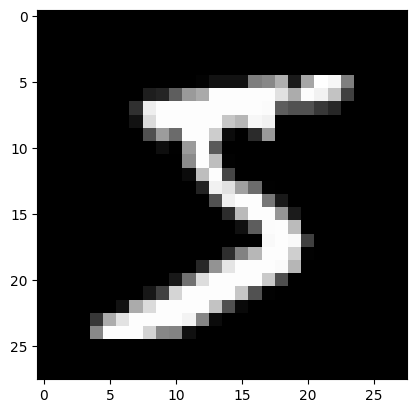

In [ ]:
train_data, test_data = datasets.MNIST('data', train=True, download=True), datasets.MNIST('data', train=False, download=True)
x_train = train_data.data.view(-1, 28*28).float() / 255.0
y_train = train_data.targets
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [36]:
TRAIN_VAL_SPLIT_RATIO = 0.8

In [47]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(x_train, y_train)
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data_global, val_data_global = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_data_global = TensorDataset(train_data_global.dataset.tensors[0], train_data_global.dataset.tensors[1])

x_test = test_data.data.view(-1, 28*28).float() / 255.0
y_test = test_data.targets
test_data_global = TensorDataset(x_test, y_test)


#### Models

In [62]:
import torch.nn as nn

# logistic regression
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.w = nn.Parameter(torch.randn(input_dim, num_classes))

    def forward(self, x):
        return x @ self.w
    
# logistic regression with separate weights
# used uniquely for coordinate descent
class LogisticRegressionCoordinate(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionCoordinate, self).__init__()
        self.param_rows = nn.ParameterList([nn.Parameter(torch.randn(num_classes)) for i in range(input_dim)])
    
    def param_matrix(self):
        return torch.stack(list(self.param_rows), dim=0)
    
    def freeze_weights(self, i_unfrozen):
        for i, param in enumerate(self.param_rows):
            # print(i, i_unfrozen)
            param.requires_grad = (i == i_unfrozen)

    def generate_coordinate(self):
        return torch.randint(0, len(self.param_rows), (1,)).item()
    
    def forward(self, x):
        return x @ self.param_matrix()

#### Loss

In [6]:
def F_alpha_loss(model, x, target, alpha):
    logits = model(x) # (batch_size, num_classes)
    # we substract max_logits from exponential 
    # and then add them back for numerical stability
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log() # (batch_size, 1)

    labels = target.unsqueeze(1) # (batch_size, 1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1) # (batch_size, num_classes)
    subtract_term = (y_train * logits).sum(dim=1, keepdim=True) # (batch_size, 1)

    loss_data = torch.mean(log_sum_exp - subtract_term) # scalar
    if isinstance(model, LogisticRegression): 
        alpha_term = 0.5 * alpha * torch.sum(model.w ** 2)
    elif isinstance(model, LogisticRegressionCoordinate):
        alpha_term = 0.5 * alpha * torch.sum(model.param_matrix() ** 2)
    else:
        raise ValueError('Model type not supported')

    return loss_data + alpha_term

#### Train/Test/Validation Routines

In [7]:
def test(model, val_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = logits.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()

    return correct / total

In [8]:
from tqdm import tqdm

def train(model, train_loader, 
          val_loader,
          alpha, optimizer, optimizer_params,
          num_epochs=10, patience=3):
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), **optimizer_params)
    epoch_losses = []
    
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            if isinstance(model, LogisticRegressionCoordinate):
                coordinate = model.generate_coordinate()
                model.freeze_weights(coordinate)
            loss = F_alpha_loss(model, x_batch, y_batch, alpha)
            loss.backward()
            if isinstance(model, LogisticRegressionCoordinate):
                opt.step(coord_list=[coordinate])
            else:
                opt.step()
            running_loss += loss.item()
        
        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        
        accuracy = test(model, val_loader)
        accuracies.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return model, accuracies, epoch_losses

In [ ]:
from torch.utils.data import DataLoader

def solve_bilevel(alpha_range,
                  train_data,
                  val_loader,
                  optimizer,
                  optimizer_params,
                  is_coordinate=False,
                  num_epochs=10,
                  batch_size=64,
                  patience=3):
    alpha_accuracies = {}
    alpha_losses = {}
    best_alpha = None
    best_acc = 0
    best_model = None

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))

    for alpha in alpha_range:
        print(f'Alpha: {alpha}')
        if is_coordinate:
            model = LogisticRegressionCoordinate(input_dim, num_classes)
        else:
            model = LogisticRegression(input_dim, num_classes)
        model, accuracies, losses = train(model, 
                                          train_loader, 
                                          val_loader, 
                                          alpha, 
                                          optimizer,
                                          optimizer_params, 
                                          num_epochs,
                                          patience)
        alpha_accuracies[alpha] = accuracies
        alpha_losses[alpha] = losses

        acc = test(model, val_loader)
        print(f'Accuracy: {acc}')
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model

    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model, alpha_losses, alpha_accuracies

#### Plotting

In [33]:
def generate_plots(alpha_range, num_epochs, d_alpha_losses, d_alpha_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    # colors = cm.Blues(np.linspace(0.2, 0.9, len(alpha_range)))
    for alpha in alpha_range:    
        # \u03b1 for symbol alpha
        epochs_range = np.arange(1, len(d_alpha_losses[alpha]) + 1)
        axes[0].plot(epochs_range, d_alpha_losses[alpha], label=f'α = {alpha}', marker = "o", linewidth = 2)#, color=color)
        axes[1].plot(epochs_range, d_alpha_accuracy[alpha], label=f'α = {alpha}', marker = "o", linewidth = 2)#, color=color)

    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

#### Final Loop

In [39]:
def run_experiment(train_data_local,
                   val_data_local,
                   test_data_local,
                   ALPHA_RANGE,
                   OPTIMIZER,
                   OPTIMIZER_PARAMS,
                   NUM_EPOCHS,
                   BATCH_SIZE = 512,
                   PATIENCE = 3,
                   IS_COORDINATE = False):
    val_loader = DataLoader(val_data_local, batch_size=BATCH_SIZE, shuffle=False)

    best_alpha, best_acc, best_model, d_alpha_losses, d_alpha_accuracy = solve_bilevel(ALPHA_RANGE, 
                                                                                        train_data_local, 
                                                                                        val_loader, 
                                                                                        OPTIMIZER, 
                                                                                        OPTIMIZER_PARAMS,
                                                                                        IS_COORDINATE, 
                                                                                        NUM_EPOCHS, 
                                                                                        BATCH_SIZE,
                                                                                        PATIENCE)
    
    generate_plots(ALPHA_RANGE[:-1], NUM_EPOCHS, d_alpha_losses, d_alpha_accuracy)

    # Test the best model
    test_loader = DataLoader(test_data_local, batch_size=BATCH_SIZE, shuffle=False)
    test_acc = test(best_model, test_loader)
    print(f'Test accuracy: {test_acc}')

    return best_alpha, best_acc, best_model, d_alpha_losses, d_alpha_accuracy

### SGD

In [28]:
from torch.optim import Optimizer

class DummySGD(Optimizer):
    def __init__(self, params, lr=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(DummySGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                p.data.add_(d_p, alpha=-group['lr'])
        return loss

In [ ]:
ALPHA_RANGE = [0, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.1, 1.0]
NUM_EPOCHS = 1000
OPTIMIZER_PARAMS = {"lr": 0.1}
BATCH_SIZE = 512
OPTIMIZER = DummySGD
PATIENCE = 5
PARAMS_DICT = {
    "train_data_local": train_data_global,
    "val_data_local": val_data_global,
    "test_data_local": test_data_global,
    "ALPHA_RANGE": ALPHA_RANGE,
    "OPTIMIZER": OPTIMIZER,
    "OPTIMIZER_PARAMS": OPTIMIZER_PARAMS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "PATIENCE": PATIENCE
}

Alpha: 0


  6%|▌         | 62/1000 [00:19<04:56,  3.16it/s]


Early stopping triggered at epoch 63
Accuracy: 0.9254166666666667
Alpha: 0.0001


  8%|▊         | 76/1000 [00:23<04:49,  3.19it/s]


Early stopping triggered at epoch 77
Accuracy: 0.92725
Alpha: 0.005


  2%|▏         | 16/1000 [00:05<05:23,  3.04it/s]


Early stopping triggered at epoch 17
Accuracy: 0.9058333333333334
Alpha: 0.01


  2%|▏         | 17/1000 [00:05<05:21,  3.05it/s]


Early stopping triggered at epoch 18
Accuracy: 0.8976666666666666
Alpha: 0.025


  1%|          | 11/1000 [00:03<05:34,  2.96it/s]


Early stopping triggered at epoch 12
Accuracy: 0.8831666666666667
Alpha: 0.05


  0%|          | 5/1000 [00:01<06:08,  2.70it/s]


Early stopping triggered at epoch 6
Accuracy: 0.87225
Alpha: 0.1


  1%|          | 9/1000 [00:03<05:40,  2.91it/s]


Early stopping triggered at epoch 10
Accuracy: 0.85125
Alpha: 1.0


  1%|          | 8/1000 [00:02<05:45,  2.87it/s]

Early stopping triggered at epoch 9
Accuracy: 0.6956666666666667
Best alpha: 0.0001, Best accuracy: 0.92725


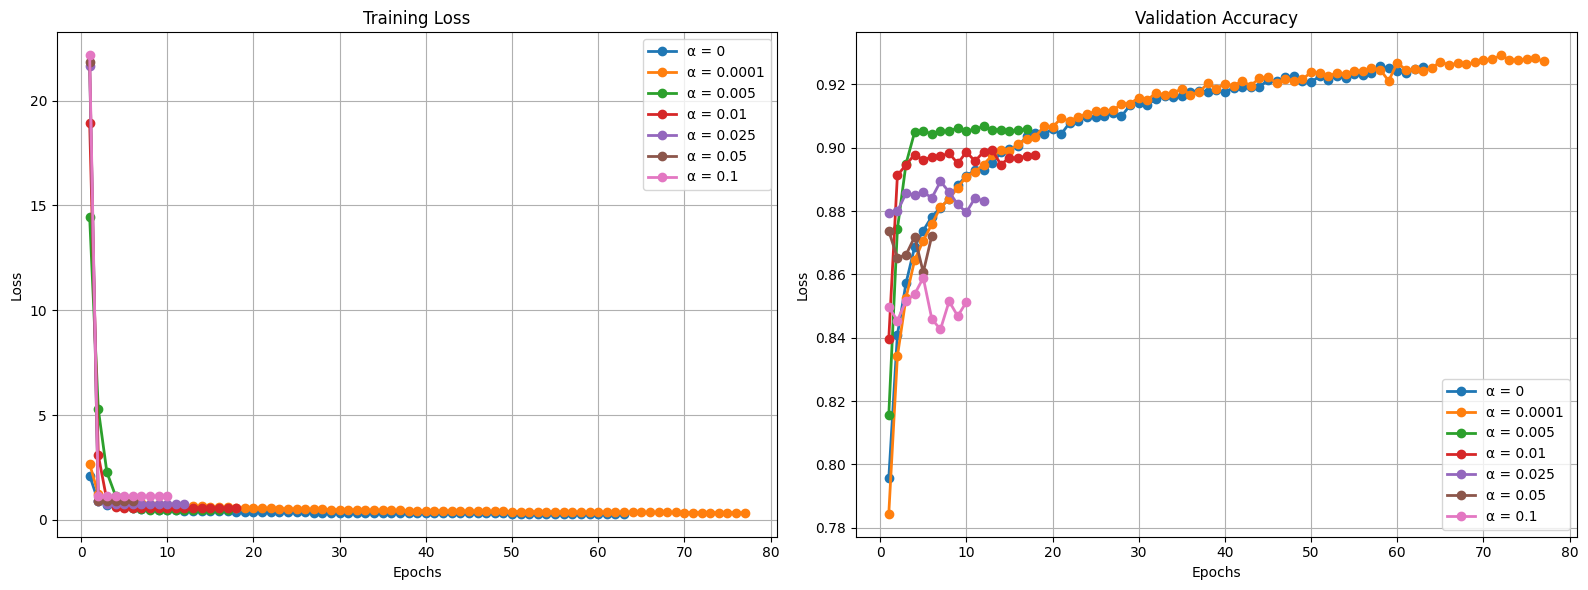

Test accuracy: 0.9226


In [54]:
best_alpha_sgd, best_acc_sgd, best_model_sgd, d_alpha_losses_sgd, d_alpha_accuracy_sgd = run_experiment(**PARAMS_DICT)

### Adam

In [56]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        # Initialize state for each parameter
        self.state = {
            p: {"m": torch.zeros_like(p.data), "v": torch.zeros_like(p.data), "t": 0}
            for p in self.params
        }
        
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            state = self.state[p]
            state["t"] += 1
            t = state["t"]
            grad = p.grad.data

            # Update biased first and second moment estimates
            state["m"].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
            state["v"].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

            m_hat = state["m"] / (1 - self.beta1 ** t)
            v_hat_current = state["v"] / (1 - self.beta2 ** t)        
            if "v_hat" not in state:
                state["v_hat"] = v_hat_current.clone()
            else:
                state["v_hat"] = torch.max(state["v_hat"], v_hat_current)

            p.data.addcdiv_(m_hat, state["v_hat"].sqrt().add_(self.eps), value=-self.lr)

        return None
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

In [57]:
ALPHA_RANGE = [0, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.1, 1.0]
NUM_EPOCHS = 1000
OPTIMIZER_PARAMS = {"lr": 0.001, "betas": (0.9, 0.999), "eps": 1e-8}
BATCH_SIZE = 512
OPTIMIZER = Adam
PATIENCE = 5
PARAMS_DICT = {
    "train_data_local": train_data_global,
    "val_data_local": val_data_global,
    "test_data_local": test_data_global,
    "ALPHA_RANGE": ALPHA_RANGE,
    "OPTIMIZER": OPTIMIZER,
    "OPTIMIZER_PARAMS": OPTIMIZER_PARAMS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "PATIENCE": PATIENCE
}

Alpha: 0


 21%|██        | 209/1000 [00:47<02:58,  4.42it/s]


Early stopping triggered at epoch 210
Accuracy: 0.8956666666666667
Alpha: 0.0001


 28%|██▊       | 276/1000 [01:03<02:45,  4.37it/s]


Early stopping triggered at epoch 277
Accuracy: 0.90125
Alpha: 0.005


 20%|██        | 202/1000 [00:45<02:59,  4.44it/s]


Early stopping triggered at epoch 203
Accuracy: 0.8998333333333334
Alpha: 0.01


 12%|█▏        | 124/1000 [00:28<03:22,  4.34it/s]


Early stopping triggered at epoch 125
Accuracy: 0.8970833333333333
Alpha: 0.025


 10%|█         | 104/1000 [00:23<03:20,  4.48it/s]


Early stopping triggered at epoch 105
Accuracy: 0.8840833333333333
Alpha: 0.05


  9%|▉         | 93/1000 [00:21<03:34,  4.23it/s]


Early stopping triggered at epoch 94
Accuracy: 0.8724166666666666
Alpha: 0.1


  9%|▊         | 86/1000 [00:20<03:33,  4.28it/s]


Early stopping triggered at epoch 87
Accuracy: 0.8598333333333333
Alpha: 1.0


  0%|          | 5/1000 [00:01<04:20,  3.82it/s]

Early stopping triggered at epoch 6
Accuracy: 0.08191666666666667
Best alpha: 0.0001, Best accuracy: 0.90125


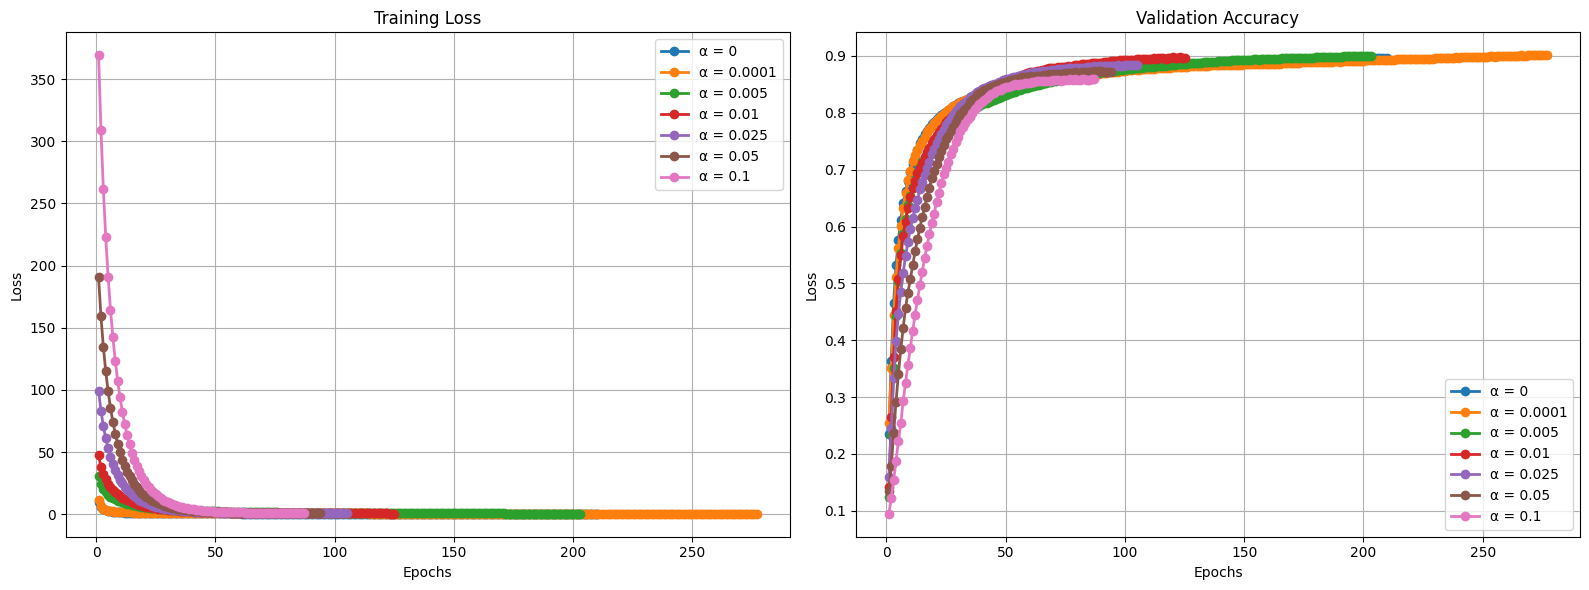

Test accuracy: 0.8972


In [58]:
best_alpha_adam, best_acc_adam, best_model_adam, d_alpha_losses_adam, d_alpha_accuracy_adam = run_experiment(**PARAMS_DICT)

### Coordinate descent

In [59]:
class CoordinateDescent(Optimizer):
    def __init__(self, params, lr=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(CoordinateDescent, self).__init__(params, defaults)

    def step(self, closure=None, coord_list=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group, coord in zip(self.param_groups, coord_list):
            p = group['params'][coord]
            if p.grad is None:
                continue
            d_p = p.grad
            p.data.add_(-group['lr'], d_p)
        return loss

In [60]:
ALPHA_RANGE = [0, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.1, 1.0]
NUM_EPOCHS = 1000
dimension = x_train.shape[1]
OPTIMIZER_PARAMS = {'lr': 0.01 * dimension}
BATCH_SIZE = 512
OPTIMIZER = CoordinateDescent
PATIENCE = 5
IS_COORDINATE = True

PARAMS_DICT = {
    "train_data_local": train_data_global,
    "val_data_local": val_data_global,
    "test_data_local": test_data_global,
    "ALPHA_RANGE": ALPHA_RANGE,
    "OPTIMIZER": OPTIMIZER,
    "OPTIMIZER_PARAMS": OPTIMIZER_PARAMS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "PATIENCE": PATIENCE,
    "IS_COORDINATE": IS_COORDINATE
}

Alpha: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 174/1000 [01:24<06:39,  2.07it/s]


Early stopping triggered at epoch 175
Accuracy: 0.83775
Alpha: 0.0001


 20%|█▉        | 195/1000 [01:37<06:42,  2.00it/s]


Early stopping triggered at epoch 196
Accuracy: 0.8453333333333334
Alpha: 0.005


 18%|█▊        | 184/1000 [01:29<06:36,  2.06it/s]


Early stopping triggered at epoch 185
Accuracy: 0.88075
Alpha: 0.01


 16%|█▋        | 163/1000 [01:20<06:51,  2.03it/s]


Early stopping triggered at epoch 164
Accuracy: 0.8860833333333333
Alpha: 0.025


 11%|█         | 107/1000 [00:52<07:19,  2.03it/s]


Early stopping triggered at epoch 108
Accuracy: 0.8790833333333333
Alpha: 0.05


  7%|▋         | 71/1000 [00:34<07:34,  2.04it/s]


Early stopping triggered at epoch 72
Accuracy: 0.8616666666666667
Alpha: 0.1


  6%|▌         | 62/1000 [00:31<07:52,  1.99it/s]


Early stopping triggered at epoch 63
Accuracy: 0.8435833333333334
Alpha: 1.0


  1%|          | 6/1000 [00:03<09:12,  1.80it/s]

Early stopping triggered at epoch 7
Accuracy: 0.09908333333333333
Best alpha: 0.01, Best accuracy: 0.8860833333333333


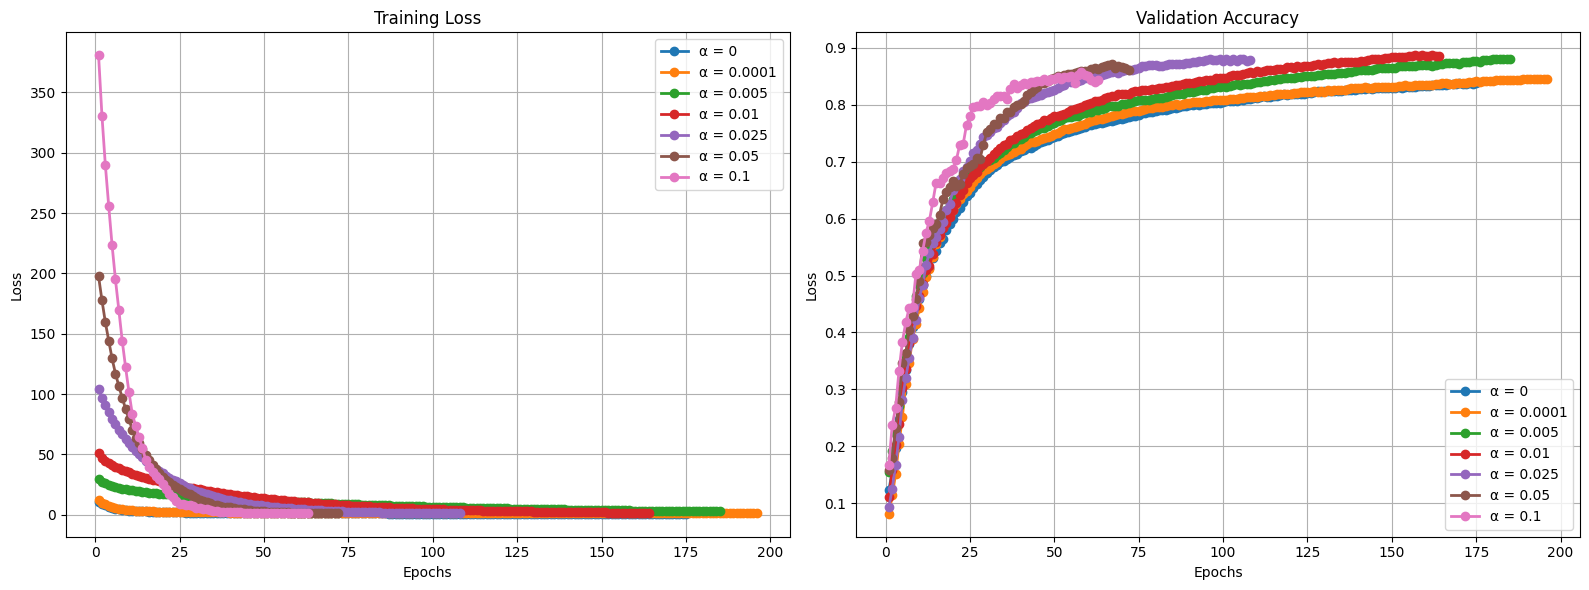

Test accuracy: 0.8912


In [63]:
best_alpha_cd, best_acc_cd, best_model_cd, d_alpha_losses_cd, d_alpha_accuracy_cd = run_experiment(**PARAMS_DICT)

### Shampoo

In this implementation, as opposed to the theoretical approach described in [Shampoo paper](https://arxiv.org/abs/1802.09568), we use modifications from the experimental section of the original paper:

- We use basic momentum on the model weights to accelerate convergence.
- We compute the \(-0.25\) power of the preconditioners only every 5 iterations, which speeds up performance since this computation is the main bottleneck.

In [64]:
class Shampoo(Optimizer):
    def __init__(self, params, lr=0.1, eps=1e-4, momentum=0.9, compute_every=5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        defaults = dict(lr=lr, eps=eps, momentum=momentum, compute_every=compute_every)
        super(Shampoo, self).__init__(params, defaults)

    def _update_preconditioner(self, M, d_p, left=True):
        # Update the preconditioner
        if left:
            return M + d_p @ d_p.t()
        else:
            return M + d_p.t() @ d_p
        
    def _matrix_inv_power(self, M, power):
        eigen_values, eigen_vectors = torch.linalg.eigh(M)
        eigen_values = torch.clamp(eigen_values, min=1e-12)
        inv_power_diagonal = torch.diag(eigen_values.pow(-power))
        return eigen_vectors @ inv_power_diagonal @ eigen_vectors.t()

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            eps = group['eps']
            momentum = group['momentum']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['L'] = eps * torch.eye(p.shape[0], device=device)
                    state['R'] = eps * torch.eye(p.shape[1], device=device)
                    state['v'] = torch.zeros_like(p)

                
                state['v'] = momentum * state['v'] + (1-momentum) * d_p
                # Update the preconditioners
                self.state[p]['L'] = self._update_preconditioner(self.state[p]['L'], self.state[p]['v'], left=True)
                self.state[p]['R'] = self._update_preconditioner(self.state[p]['R'], self.state[p]['v'], left=False)

                # Compute the update
                if state['step'] % group['compute_every'] == 0:
                    state['L_inv_sqrt'] = self._matrix_inv_power(state['L'], 0.25)
                    state['R_inv_sqrt'] = self._matrix_inv_power(state['R'], 0.25)
                update_matrix = state['L_inv_sqrt'] @ state['v'] @ state['R_inv_sqrt']
                p.data.add_(update_matrix, alpha=-group['lr'])

                self.state[p]['step'] += 1

        return loss

In [65]:
ALPHA_RANGE = [0, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.1, 1.0]
NUM_EPOCHS = 1000
OPTIMIZER_PARAMS = {'lr': 0.1, 'eps': 1e-4, 'momentum': 0.9, 'compute_every': 5}
BATCH_SIZE = 512
OPTIMIZER = Shampoo
PATIENCE = 5
PARAMS_DICT = {
    "train_data_local": train_data_global,
    "val_data_local": val_data_global,
    "test_data_local": test_data_global,
    "ALPHA_RANGE": ALPHA_RANGE,
    "OPTIMIZER": OPTIMIZER,
    "OPTIMIZER_PARAMS": OPTIMIZER_PARAMS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "PATIENCE": PATIENCE
}

Alpha: 0


 29%|██▊       | 286/1000 [04:34<11:24,  1.04it/s]


Early stopping triggered at epoch 287
Accuracy: 0.9143333333333333
Alpha: 0.0001


 31%|███       | 306/1000 [04:48<10:53,  1.06it/s]


Early stopping triggered at epoch 307
Accuracy: 0.91025
Alpha: 0.005


 33%|███▎      | 333/1000 [05:13<10:27,  1.06it/s]


Early stopping triggered at epoch 334
Accuracy: 0.9025
Alpha: 0.01


 30%|███       | 302/1000 [04:48<11:06,  1.05it/s]


Early stopping triggered at epoch 303
Accuracy: 0.8894166666666666
Alpha: 0.025


 37%|███▋      | 368/1000 [05:44<09:51,  1.07it/s]


Early stopping triggered at epoch 369
Accuracy: 0.8786666666666667
Alpha: 0.05


 38%|███▊      | 377/1000 [05:56<09:49,  1.06it/s]


Early stopping triggered at epoch 378
Accuracy: 0.8668333333333333
Alpha: 0.1


 38%|███▊      | 378/1000 [05:56<09:47,  1.06it/s]


Early stopping triggered at epoch 379
Accuracy: 0.8443333333333334
Alpha: 1.0


 45%|████▍     | 449/1000 [07:09<08:46,  1.05it/s]

Early stopping triggered at epoch 450
Accuracy: 0.6645833333333333
Best alpha: 0, Best accuracy: 0.9143333333333333


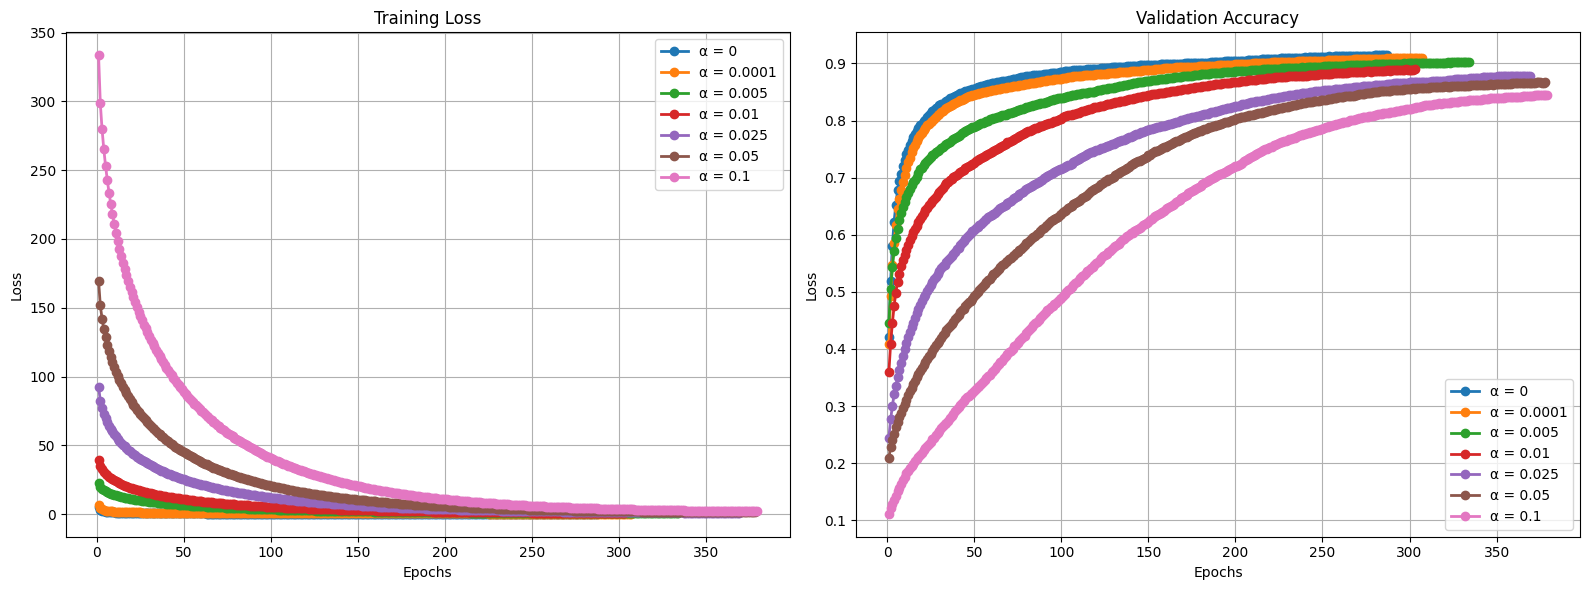

Test accuracy: 0.9075


In [66]:
best_alpha_shampoo, best_acc_shampoo, best_model_shampoo, d_alpha_losses_shampoo, d_alpha_accuracy_shampoo = run_experiment(**PARAMS_DICT)

### Comparison

In [69]:
def generate_plots_comparison(alg_names, alpha_range, d_alpha_losses, d_alpha_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    # colors = cm.Blues(np.linspace(0.2, 0.9, len(alpha_range)))
    for alg_name, alpha, d_losses, d_accuracy in zip(alg_names, alpha_range, d_alpha_losses, d_alpha_accuracy):
        # \u03b1 for symbol alpha
        epochs_range = np.arange(1, len(d_losses[alpha]) + 1)
        axes[0].plot(epochs_range, d_losses[alpha], label=f'{alg_name}, α = {alpha}', marker = "o", linewidth = 2)#, color=color)
        axes[1].plot(epochs_range, d_accuracy[alpha], label=f'{alg_name}, α = {alpha}', marker = "o", linewidth = 2)#, color=color)

    axes[0].set_title('Best Runs, Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title('Best Runs, Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

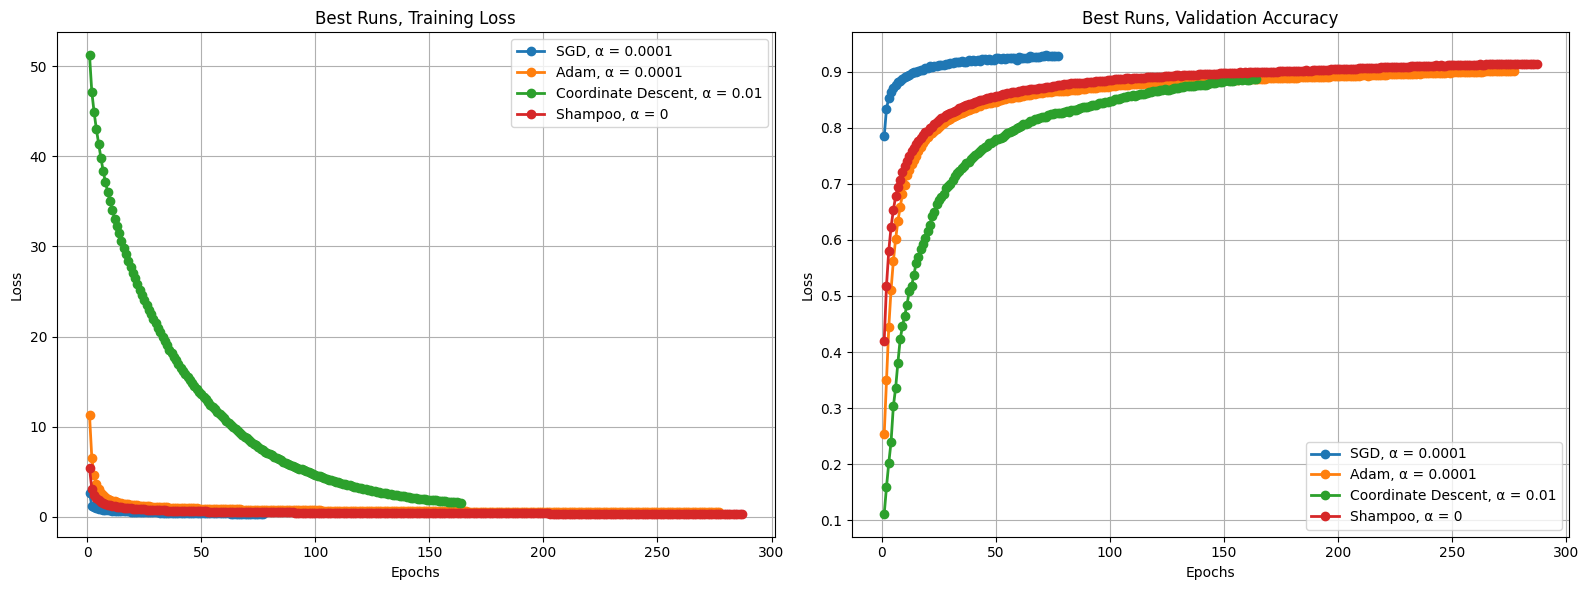

In [68]:
alg_names = ['SGD', 'Adam', 'Coordinate Descent', 'Shampoo']
alpha_range = [best_alpha_sgd, best_alpha_adam, best_alpha_cd, best_alpha_shampoo]
d_alpha_losses = [d_alpha_losses_sgd, d_alpha_losses_adam, d_alpha_losses_cd, d_alpha_losses_shampoo]
d_alpha_accuracy = [d_alpha_accuracy_sgd, d_alpha_accuracy_adam, d_alpha_accuracy_cd, d_alpha_accuracy_shampoo]

generate_plots_comparison(alg_names, alpha_range, d_alpha_losses, d_alpha_accuracy)

In [70]:
# Test the best models
test_loader = DataLoader(test_data_global, batch_size=BATCH_SIZE, shuffle=False)
test_acc_sgd = test(best_model_sgd, test_loader)
test_acc_adam = test(best_model_adam, test_loader)
test_acc_cd = test(best_model_cd, test_loader)
test_acc_shampoo = test(best_model_shampoo, test_loader)

print(f'Test accuracy SGD: {test_acc_sgd}')
print(f'Test accuracy Adam: {test_acc_adam}')
print(f'Test accuracy Coordinate Descent: {test_acc_cd}')
print(f'Test accuracy Shampoo: {test_acc_shampoo}')

Test accuracy SGD: 0.9226
Test accuracy Adam: 0.8972
Test accuracy Coordinate Descent: 0.8912
Test accuracy Shampoo: 0.9075
